In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import seaborn as sns
import cv2
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
from transformers import ViTModel, ViTFeatureExtractor

2024-11-06 09:39:28.425906: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 09:39:28.544903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 09:39:28.609021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 09:39:28.628628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 09:39:28.714248: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [3]:
# Load dataset and paths
train_csv = pd.read_csv('/home/gcekcse/Documents/ML_Project_hk/data/train.csv')
test_csv = pd.read_csv('/home/gcekcse/Documents/ML_Project_hk/data/test.csv')
base_dir = "/home/gcekcse/Documents/ML_Project_hk/data"
train_path = base_dir + "/train_images/"
test_path = base_dir + "/test_images/"

In [4]:
print(train_csv.head())
print(test_csv.head())


        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0
        id_code  diagnosis
0  e4dcca36ceb4          0
1  e50b0174690d          0
2  e5197d77ec68          0
3  e529c5757d64          0
4  e582e56e7942          0


/tmp/ipykernel_2575125/3989213185.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')


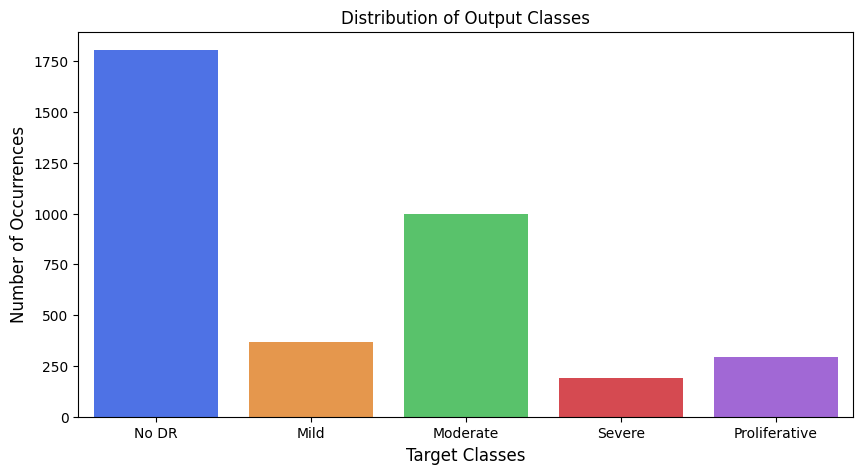

In [5]:
# Check image distribution
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
for i, x in enumerate(class_list):
    counts[x] = counts.pop(i)
plt.figure(figsize=(10, 5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [6]:
# Dataset class
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir, transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)

        # Check if the file has the correct extension
        if not img_path.endswith('.png'):
            img_path += '.png'
        
        # Load the image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

# Transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [7]:
# Dataset loading
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

# Data loaders
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=64)


In [8]:
# Hybrid Model with ResNet152 and ViT
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        
        # ResNet152 model
        self.resnet = models.resnet152(pretrained=True)
        num_ftrs_resnet = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the ResNet's classifier
        
        # Vision Transformer (ViT) model
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        
        # Combined classifier
        self.fc = nn.Sequential(
            nn.Linear(num_ftrs_resnet + 768, 512),  # Combining ResNet and ViT outputs
            nn.ReLU(),
            nn.Linear(512, 5),  # 5 output classes for diabetic retinopathy
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        resnet_features = self.resnet(x)  # ResNet output
        vit_features = self.vit(pixel_values=x).last_hidden_state[:, 0]  # ViT output (CLS token)
        
        combined = torch.cat((resnet_features, vit_features), dim=1)  # Concatenate ResNet and ViT features
        output = self.fc(combined)  # Classifier
        return output
    
# Initialize the model
model = HybridModel()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device (GPU or CPU)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gcekcse/hkenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define model file name and checkpoint path
model_name = "classifier.pt"
checkpoint_path = "/home/gcekcse/Documents/ML_Project_hk/data/models/"
model_file_path = os.path.join(checkpoint_path, model_name)
checkpoint_file = os.path.join(checkpoint_path, 'checkpoint.pt')

# Train and test loop with checkpointing
def train_and_test(e):
    # Check if there's a checkpoint to load
    if os.path.exists(checkpoint_file):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_file)
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        test_losses = checkpoint['test_losses']
        acc = checkpoint['acc']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        valid_loss_min = checkpoint['valid_loss_min']
    else:
        start_epoch = 0
        train_losses, test_losses, acc = [], [], []
        valid_loss_min = np.Inf

    model.train()
    print("Model Training started.....")
    
    for epoch in range(start_epoch, e):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f" epoch {epoch + 1} batch {batch} completed")
        
        test_loss, accuracy = 0, 0
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(validloader))
        acc.append(accuracy)
        scheduler.step()
        
        print(f"Epoch: {epoch + 1}/{e}.. "
              f"Training Loss: {running_loss/len(trainloader):.3f}.. "
              f"Valid Loss: {test_loss/len(validloader):.3f}.. "
              f"Valid Accuracy: {accuracy/len(validloader):.3f}")
        
        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'acc': acc,
            'valid_loss_min': valid_loss_min
        }
        torch.save(checkpoint, checkpoint_file)

        # Save model if validation loss has decreased
        if test_loss / len(validloader) <= valid_loss_min:
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()},
                       model_file_path)
            valid_loss_min = test_loss / len(validloader)

    print('Training Completed Successfully!')
    return train_losses, test_losses, acc



# Start Training
train_losses, valid_losses, acc = train_and_test(50)


# Function to load checkpoint and continue training
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Checkpoint loaded. Continuing training...")

# Call this function if you want to load the checkpoint and continue training
# Replace the path with your saved model path
checkpoint_path = "/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt"
load_checkpoint(checkpoint_path)

# Now you can call your `train_and_test` function again to continue training
train_and_test(epochs=10)  # Specify additional epochs for continued training


# Plotting training curves
plt.plot(train_losses, label='train_loss')
plt.plot([x.cpu().numpy() for x in valid_losses], label='valid_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

plt.plot([x.cpu().numpy() for x in acc], label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()


In [10]:
# Define class names
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

# Function to generate graphical confusion matrix
def generate_confusion_matrix(model, dataloader):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(top_class.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, [x[0] for x in y_pred])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# Generate confusion matrix for the validation set
generate_confusion_matrix(model, validloader)

In [11]:
# Load the model
model_path = "/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set model to evaluation mode

# Generate confusion matrix for the test set
generate_confusion_matrix(model, validloader)


/tmp/ipykernel_2575125/3188414865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


RuntimeError: Error(s) in loading state_dict for HybridModel:
	Missing key(s) in state_dict: "resnet.conv1.weight", "resnet.bn1.weight", "resnet.bn1.bias", "resnet.bn1.running_mean", "resnet.bn1.running_var", "resnet.layer1.0.conv1.weight", "resnet.layer1.0.bn1.weight", "resnet.layer1.0.bn1.bias", "resnet.layer1.0.bn1.running_mean", "resnet.layer1.0.bn1.running_var", "resnet.layer1.0.conv2.weight", "resnet.layer1.0.bn2.weight", "resnet.layer1.0.bn2.bias", "resnet.layer1.0.bn2.running_mean", "resnet.layer1.0.bn2.running_var", "resnet.layer1.0.conv3.weight", "resnet.layer1.0.bn3.weight", "resnet.layer1.0.bn3.bias", "resnet.layer1.0.bn3.running_mean", "resnet.layer1.0.bn3.running_var", "resnet.layer1.0.downsample.0.weight", "resnet.layer1.0.downsample.1.weight", "resnet.layer1.0.downsample.1.bias", "resnet.layer1.0.downsample.1.running_mean", "resnet.layer1.0.downsample.1.running_var", "resnet.layer1.1.conv1.weight", "resnet.layer1.1.bn1.weight", "resnet.layer1.1.bn1.bias", "resnet.layer1.1.bn1.running_mean", "resnet.layer1.1.bn1.running_var", "resnet.layer1.1.conv2.weight", "resnet.layer1.1.bn2.weight", "resnet.layer1.1.bn2.bias", "resnet.layer1.1.bn2.running_mean", "resnet.layer1.1.bn2.running_var", "resnet.layer1.1.conv3.weight", "resnet.layer1.1.bn3.weight", "resnet.layer1.1.bn3.bias", "resnet.layer1.1.bn3.running_mean", "resnet.layer1.1.bn3.running_var", "resnet.layer1.2.conv1.weight", "resnet.layer1.2.bn1.weight", "resnet.layer1.2.bn1.bias", "resnet.layer1.2.bn1.running_mean", "resnet.layer1.2.bn1.running_var", "resnet.layer1.2.conv2.weight", "resnet.layer1.2.bn2.weight", "resnet.layer1.2.bn2.bias", "resnet.layer1.2.bn2.running_mean", "resnet.layer1.2.bn2.running_var", "resnet.layer1.2.conv3.weight", "resnet.layer1.2.bn3.weight", "resnet.layer1.2.bn3.bias", "resnet.layer1.2.bn3.running_mean", "resnet.layer1.2.bn3.running_var", "resnet.layer2.0.conv1.weight", "resnet.layer2.0.bn1.weight", "resnet.layer2.0.bn1.bias", "resnet.layer2.0.bn1.running_mean", "resnet.layer2.0.bn1.running_var", "resnet.layer2.0.conv2.weight", "resnet.layer2.0.bn2.weight", "resnet.layer2.0.bn2.bias", "resnet.layer2.0.bn2.running_mean", "resnet.layer2.0.bn2.running_var", "resnet.layer2.0.conv3.weight", "resnet.layer2.0.bn3.weight", "resnet.layer2.0.bn3.bias", "resnet.layer2.0.bn3.running_mean", "resnet.layer2.0.bn3.running_var", "resnet.layer2.0.downsample.0.weight", "resnet.layer2.0.downsample.1.weight", "resnet.layer2.0.downsample.1.bias", "resnet.layer2.0.downsample.1.running_mean", "resnet.layer2.0.downsample.1.running_var", "resnet.layer2.1.conv1.weight", "resnet.layer2.1.bn1.weight", "resnet.layer2.1.bn1.bias", "resnet.layer2.1.bn1.running_mean", "resnet.layer2.1.bn1.running_var", "resnet.layer2.1.conv2.weight", "resnet.layer2.1.bn2.weight", "resnet.layer2.1.bn2.bias", "resnet.layer2.1.bn2.running_mean", "resnet.layer2.1.bn2.running_var", "resnet.layer2.1.conv3.weight", "resnet.layer2.1.bn3.weight", "resnet.layer2.1.bn3.bias", "resnet.layer2.1.bn3.running_mean", "resnet.layer2.1.bn3.running_var", "resnet.layer2.2.conv1.weight", "resnet.layer2.2.bn1.weight", "resnet.layer2.2.bn1.bias", "resnet.layer2.2.bn1.running_mean", "resnet.layer2.2.bn1.running_var", "resnet.layer2.2.conv2.weight", "resnet.layer2.2.bn2.weight", "resnet.layer2.2.bn2.bias", "resnet.layer2.2.bn2.running_mean", "resnet.layer2.2.bn2.running_var", "resnet.layer2.2.conv3.weight", "resnet.layer2.2.bn3.weight", "resnet.layer2.2.bn3.bias", "resnet.layer2.2.bn3.running_mean", "resnet.layer2.2.bn3.running_var", "resnet.layer2.3.conv1.weight", "resnet.layer2.3.bn1.weight", "resnet.layer2.3.bn1.bias", "resnet.layer2.3.bn1.running_mean", "resnet.layer2.3.bn1.running_var", "resnet.layer2.3.conv2.weight", "resnet.layer2.3.bn2.weight", "resnet.layer2.3.bn2.bias", "resnet.layer2.3.bn2.running_mean", "resnet.layer2.3.bn2.running_var", "resnet.layer2.3.conv3.weight", "resnet.layer2.3.bn3.weight", "resnet.layer2.3.bn3.bias", "resnet.layer2.3.bn3.running_mean", "resnet.layer2.3.bn3.running_var", "resnet.layer2.4.conv1.weight", "resnet.layer2.4.bn1.weight", "resnet.layer2.4.bn1.bias", "resnet.layer2.4.bn1.running_mean", "resnet.layer2.4.bn1.running_var", "resnet.layer2.4.conv2.weight", "resnet.layer2.4.bn2.weight", "resnet.layer2.4.bn2.bias", "resnet.layer2.4.bn2.running_mean", "resnet.layer2.4.bn2.running_var", "resnet.layer2.4.conv3.weight", "resnet.layer2.4.bn3.weight", "resnet.layer2.4.bn3.bias", "resnet.layer2.4.bn3.running_mean", "resnet.layer2.4.bn3.running_var", "resnet.layer2.5.conv1.weight", "resnet.layer2.5.bn1.weight", "resnet.layer2.5.bn1.bias", "resnet.layer2.5.bn1.running_mean", "resnet.layer2.5.bn1.running_var", "resnet.layer2.5.conv2.weight", "resnet.layer2.5.bn2.weight", "resnet.layer2.5.bn2.bias", "resnet.layer2.5.bn2.running_mean", "resnet.layer2.5.bn2.running_var", "resnet.layer2.5.conv3.weight", "resnet.layer2.5.bn3.weight", "resnet.layer2.5.bn3.bias", "resnet.layer2.5.bn3.running_mean", "resnet.layer2.5.bn3.running_var", "resnet.layer2.6.conv1.weight", "resnet.layer2.6.bn1.weight", "resnet.layer2.6.bn1.bias", "resnet.layer2.6.bn1.running_mean", "resnet.layer2.6.bn1.running_var", "resnet.layer2.6.conv2.weight", "resnet.layer2.6.bn2.weight", "resnet.layer2.6.bn2.bias", "resnet.layer2.6.bn2.running_mean", "resnet.layer2.6.bn2.running_var", "resnet.layer2.6.conv3.weight", "resnet.layer2.6.bn3.weight", "resnet.layer2.6.bn3.bias", "resnet.layer2.6.bn3.running_mean", "resnet.layer2.6.bn3.running_var", "resnet.layer2.7.conv1.weight", "resnet.layer2.7.bn1.weight", "resnet.layer2.7.bn1.bias", "resnet.layer2.7.bn1.running_mean", "resnet.layer2.7.bn1.running_var", "resnet.layer2.7.conv2.weight", "resnet.layer2.7.bn2.weight", "resnet.layer2.7.bn2.bias", "resnet.layer2.7.bn2.running_mean", "resnet.layer2.7.bn2.running_var", "resnet.layer2.7.conv3.weight", "resnet.layer2.7.bn3.weight", "resnet.layer2.7.bn3.bias", "resnet.layer2.7.bn3.running_mean", "resnet.layer2.7.bn3.running_var", "resnet.layer3.0.conv1.weight", "resnet.layer3.0.bn1.weight", "resnet.layer3.0.bn1.bias", "resnet.layer3.0.bn1.running_mean", "resnet.layer3.0.bn1.running_var", "resnet.layer3.0.conv2.weight", "resnet.layer3.0.bn2.weight", "resnet.layer3.0.bn2.bias", "resnet.layer3.0.bn2.running_mean", "resnet.layer3.0.bn2.running_var", "resnet.layer3.0.conv3.weight", "resnet.layer3.0.bn3.weight", "resnet.layer3.0.bn3.bias", "resnet.layer3.0.bn3.running_mean", "resnet.layer3.0.bn3.running_var", "resnet.layer3.0.downsample.0.weight", "resnet.layer3.0.downsample.1.weight", "resnet.layer3.0.downsample.1.bias", "resnet.layer3.0.downsample.1.running_mean", "resnet.layer3.0.downsample.1.running_var", "resnet.layer3.1.conv1.weight", "resnet.layer3.1.bn1.weight", "resnet.layer3.1.bn1.bias", "resnet.layer3.1.bn1.running_mean", "resnet.layer3.1.bn1.running_var", "resnet.layer3.1.conv2.weight", "resnet.layer3.1.bn2.weight", "resnet.layer3.1.bn2.bias", "resnet.layer3.1.bn2.running_mean", "resnet.layer3.1.bn2.running_var", "resnet.layer3.1.conv3.weight", "resnet.layer3.1.bn3.weight", "resnet.layer3.1.bn3.bias", "resnet.layer3.1.bn3.running_mean", "resnet.layer3.1.bn3.running_var", "resnet.layer3.2.conv1.weight", "resnet.layer3.2.bn1.weight", "resnet.layer3.2.bn1.bias", "resnet.layer3.2.bn1.running_mean", "resnet.layer3.2.bn1.running_var", "resnet.layer3.2.conv2.weight", "resnet.layer3.2.bn2.weight", "resnet.layer3.2.bn2.bias", "resnet.layer3.2.bn2.running_mean", "resnet.layer3.2.bn2.running_var", "resnet.layer3.2.conv3.weight", "resnet.layer3.2.bn3.weight", "resnet.layer3.2.bn3.bias", "resnet.layer3.2.bn3.running_mean", "resnet.layer3.2.bn3.running_var", "resnet.layer3.3.conv1.weight", "resnet.layer3.3.bn1.weight", "resnet.layer3.3.bn1.bias", "resnet.layer3.3.bn1.running_mean", "resnet.layer3.3.bn1.running_var", "resnet.layer3.3.conv2.weight", "resnet.layer3.3.bn2.weight", "resnet.layer3.3.bn2.bias", "resnet.layer3.3.bn2.running_mean", "resnet.layer3.3.bn2.running_var", "resnet.layer3.3.conv3.weight", "resnet.layer3.3.bn3.weight", "resnet.layer3.3.bn3.bias", "resnet.layer3.3.bn3.running_mean", "resnet.layer3.3.bn3.running_var", "resnet.layer3.4.conv1.weight", "resnet.layer3.4.bn1.weight", "resnet.layer3.4.bn1.bias", "resnet.layer3.4.bn1.running_mean", "resnet.layer3.4.bn1.running_var", "resnet.layer3.4.conv2.weight", "resnet.layer3.4.bn2.weight", "resnet.layer3.4.bn2.bias", "resnet.layer3.4.bn2.running_mean", "resnet.layer3.4.bn2.running_var", "resnet.layer3.4.conv3.weight", "resnet.layer3.4.bn3.weight", "resnet.layer3.4.bn3.bias", "resnet.layer3.4.bn3.running_mean", "resnet.layer3.4.bn3.running_var", "resnet.layer3.5.conv1.weight", "resnet.layer3.5.bn1.weight", "resnet.layer3.5.bn1.bias", "resnet.layer3.5.bn1.running_mean", "resnet.layer3.5.bn1.running_var", "resnet.layer3.5.conv2.weight", "resnet.layer3.5.bn2.weight", "resnet.layer3.5.bn2.bias", "resnet.layer3.5.bn2.running_mean", "resnet.layer3.5.bn2.running_var", "resnet.layer3.5.conv3.weight", "resnet.layer3.5.bn3.weight", "resnet.layer3.5.bn3.bias", "resnet.layer3.5.bn3.running_mean", "resnet.layer3.5.bn3.running_var", "resnet.layer3.6.conv1.weight", "resnet.layer3.6.bn1.weight", "resnet.layer3.6.bn1.bias", "resnet.layer3.6.bn1.running_mean", "resnet.layer3.6.bn1.running_var", "resnet.layer3.6.conv2.weight", "resnet.layer3.6.bn2.weight", "resnet.layer3.6.bn2.bias", "resnet.layer3.6.bn2.running_mean", "resnet.layer3.6.bn2.running_var", "resnet.layer3.6.conv3.weight", "resnet.layer3.6.bn3.weight", "resnet.layer3.6.bn3.bias", "resnet.layer3.6.bn3.running_mean", "resnet.layer3.6.bn3.running_var", "resnet.layer3.7.conv1.weight", "resnet.layer3.7.bn1.weight", "resnet.layer3.7.bn1.bias", "resnet.layer3.7.bn1.running_mean", "resnet.layer3.7.bn1.running_var", "resnet.layer3.7.conv2.weight", "resnet.layer3.7.bn2.weight", "resnet.layer3.7.bn2.bias", "resnet.layer3.7.bn2.running_mean", "resnet.layer3.7.bn2.running_var", "resnet.layer3.7.conv3.weight", "resnet.layer3.7.bn3.weight", "resnet.layer3.7.bn3.bias", "resnet.layer3.7.bn3.running_mean", "resnet.layer3.7.bn3.running_var", "resnet.layer3.8.conv1.weight", "resnet.layer3.8.bn1.weight", "resnet.layer3.8.bn1.bias", "resnet.layer3.8.bn1.running_mean", "resnet.layer3.8.bn1.running_var", "resnet.layer3.8.conv2.weight", "resnet.layer3.8.bn2.weight", "resnet.layer3.8.bn2.bias", "resnet.layer3.8.bn2.running_mean", "resnet.layer3.8.bn2.running_var", "resnet.layer3.8.conv3.weight", "resnet.layer3.8.bn3.weight", "resnet.layer3.8.bn3.bias", "resnet.layer3.8.bn3.running_mean", "resnet.layer3.8.bn3.running_var", "resnet.layer3.9.conv1.weight", "resnet.layer3.9.bn1.weight", "resnet.layer3.9.bn1.bias", "resnet.layer3.9.bn1.running_mean", "resnet.layer3.9.bn1.running_var", "resnet.layer3.9.conv2.weight", "resnet.layer3.9.bn2.weight", "resnet.layer3.9.bn2.bias", "resnet.layer3.9.bn2.running_mean", "resnet.layer3.9.bn2.running_var", "resnet.layer3.9.conv3.weight", "resnet.layer3.9.bn3.weight", "resnet.layer3.9.bn3.bias", "resnet.layer3.9.bn3.running_mean", "resnet.layer3.9.bn3.running_var", "resnet.layer3.10.conv1.weight", "resnet.layer3.10.bn1.weight", "resnet.layer3.10.bn1.bias", "resnet.layer3.10.bn1.running_mean", "resnet.layer3.10.bn1.running_var", "resnet.layer3.10.conv2.weight", "resnet.layer3.10.bn2.weight", "resnet.layer3.10.bn2.bias", "resnet.layer3.10.bn2.running_mean", "resnet.layer3.10.bn2.running_var", "resnet.layer3.10.conv3.weight", "resnet.layer3.10.bn3.weight", "resnet.layer3.10.bn3.bias", "resnet.layer3.10.bn3.running_mean", "resnet.layer3.10.bn3.running_var", "resnet.layer3.11.conv1.weight", "resnet.layer3.11.bn1.weight", "resnet.layer3.11.bn1.bias", "resnet.layer3.11.bn1.running_mean", "resnet.layer3.11.bn1.running_var", "resnet.layer3.11.conv2.weight", "resnet.layer3.11.bn2.weight", "resnet.layer3.11.bn2.bias", "resnet.layer3.11.bn2.running_mean", "resnet.layer3.11.bn2.running_var", "resnet.layer3.11.conv3.weight", "resnet.layer3.11.bn3.weight", "resnet.layer3.11.bn3.bias", "resnet.layer3.11.bn3.running_mean", "resnet.layer3.11.bn3.running_var", "resnet.layer3.12.conv1.weight", "resnet.layer3.12.bn1.weight", "resnet.layer3.12.bn1.bias", "resnet.layer3.12.bn1.running_mean", "resnet.layer3.12.bn1.running_var", "resnet.layer3.12.conv2.weight", "resnet.layer3.12.bn2.weight", "resnet.layer3.12.bn2.bias", "resnet.layer3.12.bn2.running_mean", "resnet.layer3.12.bn2.running_var", "resnet.layer3.12.conv3.weight", "resnet.layer3.12.bn3.weight", "resnet.layer3.12.bn3.bias", "resnet.layer3.12.bn3.running_mean", "resnet.layer3.12.bn3.running_var", "resnet.layer3.13.conv1.weight", "resnet.layer3.13.bn1.weight", "resnet.layer3.13.bn1.bias", "resnet.layer3.13.bn1.running_mean", "resnet.layer3.13.bn1.running_var", "resnet.layer3.13.conv2.weight", "resnet.layer3.13.bn2.weight", "resnet.layer3.13.bn2.bias", "resnet.layer3.13.bn2.running_mean", "resnet.layer3.13.bn2.running_var", "resnet.layer3.13.conv3.weight", "resnet.layer3.13.bn3.weight", "resnet.layer3.13.bn3.bias", "resnet.layer3.13.bn3.running_mean", "resnet.layer3.13.bn3.running_var", "resnet.layer3.14.conv1.weight", "resnet.layer3.14.bn1.weight", "resnet.layer3.14.bn1.bias", "resnet.layer3.14.bn1.running_mean", "resnet.layer3.14.bn1.running_var", "resnet.layer3.14.conv2.weight", "resnet.layer3.14.bn2.weight", "resnet.layer3.14.bn2.bias", "resnet.layer3.14.bn2.running_mean", "resnet.layer3.14.bn2.running_var", "resnet.layer3.14.conv3.weight", "resnet.layer3.14.bn3.weight", "resnet.layer3.14.bn3.bias", "resnet.layer3.14.bn3.running_mean", "resnet.layer3.14.bn3.running_var", "resnet.layer3.15.conv1.weight", "resnet.layer3.15.bn1.weight", "resnet.layer3.15.bn1.bias", "resnet.layer3.15.bn1.running_mean", "resnet.layer3.15.bn1.running_var", "resnet.layer3.15.conv2.weight", "resnet.layer3.15.bn2.weight", "resnet.layer3.15.bn2.bias", "resnet.layer3.15.bn2.running_mean", "resnet.layer3.15.bn2.running_var", "resnet.layer3.15.conv3.weight", "resnet.layer3.15.bn3.weight", "resnet.layer3.15.bn3.bias", "resnet.layer3.15.bn3.running_mean", "resnet.layer3.15.bn3.running_var", "resnet.layer3.16.conv1.weight", "resnet.layer3.16.bn1.weight", "resnet.layer3.16.bn1.bias", "resnet.layer3.16.bn1.running_mean", "resnet.layer3.16.bn1.running_var", "resnet.layer3.16.conv2.weight", "resnet.layer3.16.bn2.weight", "resnet.layer3.16.bn2.bias", "resnet.layer3.16.bn2.running_mean", "resnet.layer3.16.bn2.running_var", "resnet.layer3.16.conv3.weight", "resnet.layer3.16.bn3.weight", "resnet.layer3.16.bn3.bias", "resnet.layer3.16.bn3.running_mean", "resnet.layer3.16.bn3.running_var", "resnet.layer3.17.conv1.weight", "resnet.layer3.17.bn1.weight", "resnet.layer3.17.bn1.bias", "resnet.layer3.17.bn1.running_mean", "resnet.layer3.17.bn1.running_var", "resnet.layer3.17.conv2.weight", "resnet.layer3.17.bn2.weight", "resnet.layer3.17.bn2.bias", "resnet.layer3.17.bn2.running_mean", "resnet.layer3.17.bn2.running_var", "resnet.layer3.17.conv3.weight", "resnet.layer3.17.bn3.weight", "resnet.layer3.17.bn3.bias", "resnet.layer3.17.bn3.running_mean", "resnet.layer3.17.bn3.running_var", "resnet.layer3.18.conv1.weight", "resnet.layer3.18.bn1.weight", "resnet.layer3.18.bn1.bias", "resnet.layer3.18.bn1.running_mean", "resnet.layer3.18.bn1.running_var", "resnet.layer3.18.conv2.weight", "resnet.layer3.18.bn2.weight", "resnet.layer3.18.bn2.bias", "resnet.layer3.18.bn2.running_mean", "resnet.layer3.18.bn2.running_var", "resnet.layer3.18.conv3.weight", "resnet.layer3.18.bn3.weight", "resnet.layer3.18.bn3.bias", "resnet.layer3.18.bn3.running_mean", "resnet.layer3.18.bn3.running_var", "resnet.layer3.19.conv1.weight", "resnet.layer3.19.bn1.weight", "resnet.layer3.19.bn1.bias", "resnet.layer3.19.bn1.running_mean", "resnet.layer3.19.bn1.running_var", "resnet.layer3.19.conv2.weight", "resnet.layer3.19.bn2.weight", "resnet.layer3.19.bn2.bias", "resnet.layer3.19.bn2.running_mean", "resnet.layer3.19.bn2.running_var", "resnet.layer3.19.conv3.weight", "resnet.layer3.19.bn3.weight", "resnet.layer3.19.bn3.bias", "resnet.layer3.19.bn3.running_mean", "resnet.layer3.19.bn3.running_var", "resnet.layer3.20.conv1.weight", "resnet.layer3.20.bn1.weight", "resnet.layer3.20.bn1.bias", "resnet.layer3.20.bn1.running_mean", "resnet.layer3.20.bn1.running_var", "resnet.layer3.20.conv2.weight", "resnet.layer3.20.bn2.weight", "resnet.layer3.20.bn2.bias", "resnet.layer3.20.bn2.running_mean", "resnet.layer3.20.bn2.running_var", "resnet.layer3.20.conv3.weight", "resnet.layer3.20.bn3.weight", "resnet.layer3.20.bn3.bias", "resnet.layer3.20.bn3.running_mean", "resnet.layer3.20.bn3.running_var", "resnet.layer3.21.conv1.weight", "resnet.layer3.21.bn1.weight", "resnet.layer3.21.bn1.bias", "resnet.layer3.21.bn1.running_mean", "resnet.layer3.21.bn1.running_var", "resnet.layer3.21.conv2.weight", "resnet.layer3.21.bn2.weight", "resnet.layer3.21.bn2.bias", "resnet.layer3.21.bn2.running_mean", "resnet.layer3.21.bn2.running_var", "resnet.layer3.21.conv3.weight", "resnet.layer3.21.bn3.weight", "resnet.layer3.21.bn3.bias", "resnet.layer3.21.bn3.running_mean", "resnet.layer3.21.bn3.running_var", "resnet.layer3.22.conv1.weight", "resnet.layer3.22.bn1.weight", "resnet.layer3.22.bn1.bias", "resnet.layer3.22.bn1.running_mean", "resnet.layer3.22.bn1.running_var", "resnet.layer3.22.conv2.weight", "resnet.layer3.22.bn2.weight", "resnet.layer3.22.bn2.bias", "resnet.layer3.22.bn2.running_mean", "resnet.layer3.22.bn2.running_var", "resnet.layer3.22.conv3.weight", "resnet.layer3.22.bn3.weight", "resnet.layer3.22.bn3.bias", "resnet.layer3.22.bn3.running_mean", "resnet.layer3.22.bn3.running_var", "resnet.layer3.23.conv1.weight", "resnet.layer3.23.bn1.weight", "resnet.layer3.23.bn1.bias", "resnet.layer3.23.bn1.running_mean", "resnet.layer3.23.bn1.running_var", "resnet.layer3.23.conv2.weight", "resnet.layer3.23.bn2.weight", "resnet.layer3.23.bn2.bias", "resnet.layer3.23.bn2.running_mean", "resnet.layer3.23.bn2.running_var", "resnet.layer3.23.conv3.weight", "resnet.layer3.23.bn3.weight", "resnet.layer3.23.bn3.bias", "resnet.layer3.23.bn3.running_mean", "resnet.layer3.23.bn3.running_var", "resnet.layer3.24.conv1.weight", "resnet.layer3.24.bn1.weight", "resnet.layer3.24.bn1.bias", "resnet.layer3.24.bn1.running_mean", "resnet.layer3.24.bn1.running_var", "resnet.layer3.24.conv2.weight", "resnet.layer3.24.bn2.weight", "resnet.layer3.24.bn2.bias", "resnet.layer3.24.bn2.running_mean", "resnet.layer3.24.bn2.running_var", "resnet.layer3.24.conv3.weight", "resnet.layer3.24.bn3.weight", "resnet.layer3.24.bn3.bias", "resnet.layer3.24.bn3.running_mean", "resnet.layer3.24.bn3.running_var", "resnet.layer3.25.conv1.weight", "resnet.layer3.25.bn1.weight", "resnet.layer3.25.bn1.bias", "resnet.layer3.25.bn1.running_mean", "resnet.layer3.25.bn1.running_var", "resnet.layer3.25.conv2.weight", "resnet.layer3.25.bn2.weight", "resnet.layer3.25.bn2.bias", "resnet.layer3.25.bn2.running_mean", "resnet.layer3.25.bn2.running_var", "resnet.layer3.25.conv3.weight", "resnet.layer3.25.bn3.weight", "resnet.layer3.25.bn3.bias", "resnet.layer3.25.bn3.running_mean", "resnet.layer3.25.bn3.running_var", "resnet.layer3.26.conv1.weight", "resnet.layer3.26.bn1.weight", "resnet.layer3.26.bn1.bias", "resnet.layer3.26.bn1.running_mean", "resnet.layer3.26.bn1.running_var", "resnet.layer3.26.conv2.weight", "resnet.layer3.26.bn2.weight", "resnet.layer3.26.bn2.bias", "resnet.layer3.26.bn2.running_mean", "resnet.layer3.26.bn2.running_var", "resnet.layer3.26.conv3.weight", "resnet.layer3.26.bn3.weight", "resnet.layer3.26.bn3.bias", "resnet.layer3.26.bn3.running_mean", "resnet.layer3.26.bn3.running_var", "resnet.layer3.27.conv1.weight", "resnet.layer3.27.bn1.weight", "resnet.layer3.27.bn1.bias", "resnet.layer3.27.bn1.running_mean", "resnet.layer3.27.bn1.running_var", "resnet.layer3.27.conv2.weight", "resnet.layer3.27.bn2.weight", "resnet.layer3.27.bn2.bias", "resnet.layer3.27.bn2.running_mean", "resnet.layer3.27.bn2.running_var", "resnet.layer3.27.conv3.weight", "resnet.layer3.27.bn3.weight", "resnet.layer3.27.bn3.bias", "resnet.layer3.27.bn3.running_mean", "resnet.layer3.27.bn3.running_var", "resnet.layer3.28.conv1.weight", "resnet.layer3.28.bn1.weight", "resnet.layer3.28.bn1.bias", "resnet.layer3.28.bn1.running_mean", "resnet.layer3.28.bn1.running_var", "resnet.layer3.28.conv2.weight", "resnet.layer3.28.bn2.weight", "resnet.layer3.28.bn2.bias", "resnet.layer3.28.bn2.running_mean", "resnet.layer3.28.bn2.running_var", "resnet.layer3.28.conv3.weight", "resnet.layer3.28.bn3.weight", "resnet.layer3.28.bn3.bias", "resnet.layer3.28.bn3.running_mean", "resnet.layer3.28.bn3.running_var", "resnet.layer3.29.conv1.weight", "resnet.layer3.29.bn1.weight", "resnet.layer3.29.bn1.bias", "resnet.layer3.29.bn1.running_mean", "resnet.layer3.29.bn1.running_var", "resnet.layer3.29.conv2.weight", "resnet.layer3.29.bn2.weight", "resnet.layer3.29.bn2.bias", "resnet.layer3.29.bn2.running_mean", "resnet.layer3.29.bn2.running_var", "resnet.layer3.29.conv3.weight", "resnet.layer3.29.bn3.weight", "resnet.layer3.29.bn3.bias", "resnet.layer3.29.bn3.running_mean", "resnet.layer3.29.bn3.running_var", "resnet.layer3.30.conv1.weight", "resnet.layer3.30.bn1.weight", "resnet.layer3.30.bn1.bias", "resnet.layer3.30.bn1.running_mean", "resnet.layer3.30.bn1.running_var", "resnet.layer3.30.conv2.weight", "resnet.layer3.30.bn2.weight", "resnet.layer3.30.bn2.bias", "resnet.layer3.30.bn2.running_mean", "resnet.layer3.30.bn2.running_var", "resnet.layer3.30.conv3.weight", "resnet.layer3.30.bn3.weight", "resnet.layer3.30.bn3.bias", "resnet.layer3.30.bn3.running_mean", "resnet.layer3.30.bn3.running_var", "resnet.layer3.31.conv1.weight", "resnet.layer3.31.bn1.weight", "resnet.layer3.31.bn1.bias", "resnet.layer3.31.bn1.running_mean", "resnet.layer3.31.bn1.running_var", "resnet.layer3.31.conv2.weight", "resnet.layer3.31.bn2.weight", "resnet.layer3.31.bn2.bias", "resnet.layer3.31.bn2.running_mean", "resnet.layer3.31.bn2.running_var", "resnet.layer3.31.conv3.weight", "resnet.layer3.31.bn3.weight", "resnet.layer3.31.bn3.bias", "resnet.layer3.31.bn3.running_mean", "resnet.layer3.31.bn3.running_var", "resnet.layer3.32.conv1.weight", "resnet.layer3.32.bn1.weight", "resnet.layer3.32.bn1.bias", "resnet.layer3.32.bn1.running_mean", "resnet.layer3.32.bn1.running_var", "resnet.layer3.32.conv2.weight", "resnet.layer3.32.bn2.weight", "resnet.layer3.32.bn2.bias", "resnet.layer3.32.bn2.running_mean", "resnet.layer3.32.bn2.running_var", "resnet.layer3.32.conv3.weight", "resnet.layer3.32.bn3.weight", "resnet.layer3.32.bn3.bias", "resnet.layer3.32.bn3.running_mean", "resnet.layer3.32.bn3.running_var", "resnet.layer3.33.conv1.weight", "resnet.layer3.33.bn1.weight", "resnet.layer3.33.bn1.bias", "resnet.layer3.33.bn1.running_mean", "resnet.layer3.33.bn1.running_var", "resnet.layer3.33.conv2.weight", "resnet.layer3.33.bn2.weight", "resnet.layer3.33.bn2.bias", "resnet.layer3.33.bn2.running_mean", "resnet.layer3.33.bn2.running_var", "resnet.layer3.33.conv3.weight", "resnet.layer3.33.bn3.weight", "resnet.layer3.33.bn3.bias", "resnet.layer3.33.bn3.running_mean", "resnet.layer3.33.bn3.running_var", "resnet.layer3.34.conv1.weight", "resnet.layer3.34.bn1.weight", "resnet.layer3.34.bn1.bias", "resnet.layer3.34.bn1.running_mean", "resnet.layer3.34.bn1.running_var", "resnet.layer3.34.conv2.weight", "resnet.layer3.34.bn2.weight", "resnet.layer3.34.bn2.bias", "resnet.layer3.34.bn2.running_mean", "resnet.layer3.34.bn2.running_var", "resnet.layer3.34.conv3.weight", "resnet.layer3.34.bn3.weight", "resnet.layer3.34.bn3.bias", "resnet.layer3.34.bn3.running_mean", "resnet.layer3.34.bn3.running_var", "resnet.layer3.35.conv1.weight", "resnet.layer3.35.bn1.weight", "resnet.layer3.35.bn1.bias", "resnet.layer3.35.bn1.running_mean", "resnet.layer3.35.bn1.running_var", "resnet.layer3.35.conv2.weight", "resnet.layer3.35.bn2.weight", "resnet.layer3.35.bn2.bias", "resnet.layer3.35.bn2.running_mean", "resnet.layer3.35.bn2.running_var", "resnet.layer3.35.conv3.weight", "resnet.layer3.35.bn3.weight", "resnet.layer3.35.bn3.bias", "resnet.layer3.35.bn3.running_mean", "resnet.layer3.35.bn3.running_var", "resnet.layer4.0.conv1.weight", "resnet.layer4.0.bn1.weight", "resnet.layer4.0.bn1.bias", "resnet.layer4.0.bn1.running_mean", "resnet.layer4.0.bn1.running_var", "resnet.layer4.0.conv2.weight", "resnet.layer4.0.bn2.weight", "resnet.layer4.0.bn2.bias", "resnet.layer4.0.bn2.running_mean", "resnet.layer4.0.bn2.running_var", "resnet.layer4.0.conv3.weight", "resnet.layer4.0.bn3.weight", "resnet.layer4.0.bn3.bias", "resnet.layer4.0.bn3.running_mean", "resnet.layer4.0.bn3.running_var", "resnet.layer4.0.downsample.0.weight", "resnet.layer4.0.downsample.1.weight", "resnet.layer4.0.downsample.1.bias", "resnet.layer4.0.downsample.1.running_mean", "resnet.layer4.0.downsample.1.running_var", "resnet.layer4.1.conv1.weight", "resnet.layer4.1.bn1.weight", "resnet.layer4.1.bn1.bias", "resnet.layer4.1.bn1.running_mean", "resnet.layer4.1.bn1.running_var", "resnet.layer4.1.conv2.weight", "resnet.layer4.1.bn2.weight", "resnet.layer4.1.bn2.bias", "resnet.layer4.1.bn2.running_mean", "resnet.layer4.1.bn2.running_var", "resnet.layer4.1.conv3.weight", "resnet.layer4.1.bn3.weight", "resnet.layer4.1.bn3.bias", "resnet.layer4.1.bn3.running_mean", "resnet.layer4.1.bn3.running_var", "resnet.layer4.2.conv1.weight", "resnet.layer4.2.bn1.weight", "resnet.layer4.2.bn1.bias", "resnet.layer4.2.bn1.running_mean", "resnet.layer4.2.bn1.running_var", "resnet.layer4.2.conv2.weight", "resnet.layer4.2.bn2.weight", "resnet.layer4.2.bn2.bias", "resnet.layer4.2.bn2.running_mean", "resnet.layer4.2.bn2.running_var", "resnet.layer4.2.conv3.weight", "resnet.layer4.2.bn3.weight", "resnet.layer4.2.bn3.bias", "resnet.layer4.2.bn3.running_mean", "resnet.layer4.2.bn3.running_var", "vit.embeddings.cls_token", "vit.embeddings.position_embeddings", "vit.embeddings.patch_embeddings.projection.weight", "vit.embeddings.patch_embeddings.projection.bias", "vit.encoder.layer.0.attention.attention.query.weight", "vit.encoder.layer.0.attention.attention.query.bias", "vit.encoder.layer.0.attention.attention.key.weight", "vit.encoder.layer.0.attention.attention.key.bias", "vit.encoder.layer.0.attention.attention.value.weight", "vit.encoder.layer.0.attention.attention.value.bias", "vit.encoder.layer.0.attention.output.dense.weight", "vit.encoder.layer.0.attention.output.dense.bias", "vit.encoder.layer.0.intermediate.dense.weight", "vit.encoder.layer.0.intermediate.dense.bias", "vit.encoder.layer.0.output.dense.weight", "vit.encoder.layer.0.output.dense.bias", "vit.encoder.layer.0.layernorm_before.weight", "vit.encoder.layer.0.layernorm_before.bias", "vit.encoder.layer.0.layernorm_after.weight", "vit.encoder.layer.0.layernorm_after.bias", "vit.encoder.layer.1.attention.attention.query.weight", "vit.encoder.layer.1.attention.attention.query.bias", "vit.encoder.layer.1.attention.attention.key.weight", "vit.encoder.layer.1.attention.attention.key.bias", "vit.encoder.layer.1.attention.attention.value.weight", "vit.encoder.layer.1.attention.attention.value.bias", "vit.encoder.layer.1.attention.output.dense.weight", "vit.encoder.layer.1.attention.output.dense.bias", "vit.encoder.layer.1.intermediate.dense.weight", "vit.encoder.layer.1.intermediate.dense.bias", "vit.encoder.layer.1.output.dense.weight", "vit.encoder.layer.1.output.dense.bias", "vit.encoder.layer.1.layernorm_before.weight", "vit.encoder.layer.1.layernorm_before.bias", "vit.encoder.layer.1.layernorm_after.weight", "vit.encoder.layer.1.layernorm_after.bias", "vit.encoder.layer.2.attention.attention.query.weight", "vit.encoder.layer.2.attention.attention.query.bias", "vit.encoder.layer.2.attention.attention.key.weight", "vit.encoder.layer.2.attention.attention.key.bias", "vit.encoder.layer.2.attention.attention.value.weight", "vit.encoder.layer.2.attention.attention.value.bias", "vit.encoder.layer.2.attention.output.dense.weight", "vit.encoder.layer.2.attention.output.dense.bias", "vit.encoder.layer.2.intermediate.dense.weight", "vit.encoder.layer.2.intermediate.dense.bias", "vit.encoder.layer.2.output.dense.weight", "vit.encoder.layer.2.output.dense.bias", "vit.encoder.layer.2.layernorm_before.weight", "vit.encoder.layer.2.layernorm_before.bias", "vit.encoder.layer.2.layernorm_after.weight", "vit.encoder.layer.2.layernorm_after.bias", "vit.encoder.layer.3.attention.attention.query.weight", "vit.encoder.layer.3.attention.attention.query.bias", "vit.encoder.layer.3.attention.attention.key.weight", "vit.encoder.layer.3.attention.attention.key.bias", "vit.encoder.layer.3.attention.attention.value.weight", "vit.encoder.layer.3.attention.attention.value.bias", "vit.encoder.layer.3.attention.output.dense.weight", "vit.encoder.layer.3.attention.output.dense.bias", "vit.encoder.layer.3.intermediate.dense.weight", "vit.encoder.layer.3.intermediate.dense.bias", "vit.encoder.layer.3.output.dense.weight", "vit.encoder.layer.3.output.dense.bias", "vit.encoder.layer.3.layernorm_before.weight", "vit.encoder.layer.3.layernorm_before.bias", "vit.encoder.layer.3.layernorm_after.weight", "vit.encoder.layer.3.layernorm_after.bias", "vit.encoder.layer.4.attention.attention.query.weight", "vit.encoder.layer.4.attention.attention.query.bias", "vit.encoder.layer.4.attention.attention.key.weight", "vit.encoder.layer.4.attention.attention.key.bias", "vit.encoder.layer.4.attention.attention.value.weight", "vit.encoder.layer.4.attention.attention.value.bias", "vit.encoder.layer.4.attention.output.dense.weight", "vit.encoder.layer.4.attention.output.dense.bias", "vit.encoder.layer.4.intermediate.dense.weight", "vit.encoder.layer.4.intermediate.dense.bias", "vit.encoder.layer.4.output.dense.weight", "vit.encoder.layer.4.output.dense.bias", "vit.encoder.layer.4.layernorm_before.weight", "vit.encoder.layer.4.layernorm_before.bias", "vit.encoder.layer.4.layernorm_after.weight", "vit.encoder.layer.4.layernorm_after.bias", "vit.encoder.layer.5.attention.attention.query.weight", "vit.encoder.layer.5.attention.attention.query.bias", "vit.encoder.layer.5.attention.attention.key.weight", "vit.encoder.layer.5.attention.attention.key.bias", "vit.encoder.layer.5.attention.attention.value.weight", "vit.encoder.layer.5.attention.attention.value.bias", "vit.encoder.layer.5.attention.output.dense.weight", "vit.encoder.layer.5.attention.output.dense.bias", "vit.encoder.layer.5.intermediate.dense.weight", "vit.encoder.layer.5.intermediate.dense.bias", "vit.encoder.layer.5.output.dense.weight", "vit.encoder.layer.5.output.dense.bias", "vit.encoder.layer.5.layernorm_before.weight", "vit.encoder.layer.5.layernorm_before.bias", "vit.encoder.layer.5.layernorm_after.weight", "vit.encoder.layer.5.layernorm_after.bias", "vit.encoder.layer.6.attention.attention.query.weight", "vit.encoder.layer.6.attention.attention.query.bias", "vit.encoder.layer.6.attention.attention.key.weight", "vit.encoder.layer.6.attention.attention.key.bias", "vit.encoder.layer.6.attention.attention.value.weight", "vit.encoder.layer.6.attention.attention.value.bias", "vit.encoder.layer.6.attention.output.dense.weight", "vit.encoder.layer.6.attention.output.dense.bias", "vit.encoder.layer.6.intermediate.dense.weight", "vit.encoder.layer.6.intermediate.dense.bias", "vit.encoder.layer.6.output.dense.weight", "vit.encoder.layer.6.output.dense.bias", "vit.encoder.layer.6.layernorm_before.weight", "vit.encoder.layer.6.layernorm_before.bias", "vit.encoder.layer.6.layernorm_after.weight", "vit.encoder.layer.6.layernorm_after.bias", "vit.encoder.layer.7.attention.attention.query.weight", "vit.encoder.layer.7.attention.attention.query.bias", "vit.encoder.layer.7.attention.attention.key.weight", "vit.encoder.layer.7.attention.attention.key.bias", "vit.encoder.layer.7.attention.attention.value.weight", "vit.encoder.layer.7.attention.attention.value.bias", "vit.encoder.layer.7.attention.output.dense.weight", "vit.encoder.layer.7.attention.output.dense.bias", "vit.encoder.layer.7.intermediate.dense.weight", "vit.encoder.layer.7.intermediate.dense.bias", "vit.encoder.layer.7.output.dense.weight", "vit.encoder.layer.7.output.dense.bias", "vit.encoder.layer.7.layernorm_before.weight", "vit.encoder.layer.7.layernorm_before.bias", "vit.encoder.layer.7.layernorm_after.weight", "vit.encoder.layer.7.layernorm_after.bias", "vit.encoder.layer.8.attention.attention.query.weight", "vit.encoder.layer.8.attention.attention.query.bias", "vit.encoder.layer.8.attention.attention.key.weight", "vit.encoder.layer.8.attention.attention.key.bias", "vit.encoder.layer.8.attention.attention.value.weight", "vit.encoder.layer.8.attention.attention.value.bias", "vit.encoder.layer.8.attention.output.dense.weight", "vit.encoder.layer.8.attention.output.dense.bias", "vit.encoder.layer.8.intermediate.dense.weight", "vit.encoder.layer.8.intermediate.dense.bias", "vit.encoder.layer.8.output.dense.weight", "vit.encoder.layer.8.output.dense.bias", "vit.encoder.layer.8.layernorm_before.weight", "vit.encoder.layer.8.layernorm_before.bias", "vit.encoder.layer.8.layernorm_after.weight", "vit.encoder.layer.8.layernorm_after.bias", "vit.encoder.layer.9.attention.attention.query.weight", "vit.encoder.layer.9.attention.attention.query.bias", "vit.encoder.layer.9.attention.attention.key.weight", "vit.encoder.layer.9.attention.attention.key.bias", "vit.encoder.layer.9.attention.attention.value.weight", "vit.encoder.layer.9.attention.attention.value.bias", "vit.encoder.layer.9.attention.output.dense.weight", "vit.encoder.layer.9.attention.output.dense.bias", "vit.encoder.layer.9.intermediate.dense.weight", "vit.encoder.layer.9.intermediate.dense.bias", "vit.encoder.layer.9.output.dense.weight", "vit.encoder.layer.9.output.dense.bias", "vit.encoder.layer.9.layernorm_before.weight", "vit.encoder.layer.9.layernorm_before.bias", "vit.encoder.layer.9.layernorm_after.weight", "vit.encoder.layer.9.layernorm_after.bias", "vit.encoder.layer.10.attention.attention.query.weight", "vit.encoder.layer.10.attention.attention.query.bias", "vit.encoder.layer.10.attention.attention.key.weight", "vit.encoder.layer.10.attention.attention.key.bias", "vit.encoder.layer.10.attention.attention.value.weight", "vit.encoder.layer.10.attention.attention.value.bias", "vit.encoder.layer.10.attention.output.dense.weight", "vit.encoder.layer.10.attention.output.dense.bias", "vit.encoder.layer.10.intermediate.dense.weight", "vit.encoder.layer.10.intermediate.dense.bias", "vit.encoder.layer.10.output.dense.weight", "vit.encoder.layer.10.output.dense.bias", "vit.encoder.layer.10.layernorm_before.weight", "vit.encoder.layer.10.layernorm_before.bias", "vit.encoder.layer.10.layernorm_after.weight", "vit.encoder.layer.10.layernorm_after.bias", "vit.encoder.layer.11.attention.attention.query.weight", "vit.encoder.layer.11.attention.attention.query.bias", "vit.encoder.layer.11.attention.attention.key.weight", "vit.encoder.layer.11.attention.attention.key.bias", "vit.encoder.layer.11.attention.attention.value.weight", "vit.encoder.layer.11.attention.attention.value.bias", "vit.encoder.layer.11.attention.output.dense.weight", "vit.encoder.layer.11.attention.output.dense.bias", "vit.encoder.layer.11.intermediate.dense.weight", "vit.encoder.layer.11.intermediate.dense.bias", "vit.encoder.layer.11.output.dense.weight", "vit.encoder.layer.11.output.dense.bias", "vit.encoder.layer.11.layernorm_before.weight", "vit.encoder.layer.11.layernorm_before.bias", "vit.encoder.layer.11.layernorm_after.weight", "vit.encoder.layer.11.layernorm_after.bias", "vit.layernorm.weight", "vit.layernorm.bias", "vit.pooler.dense.weight", "vit.pooler.dense.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer2.4.conv1.weight", "layer2.4.bn1.weight", "layer2.4.bn1.bias", "layer2.4.bn1.running_mean", "layer2.4.bn1.running_var", "layer2.4.bn1.num_batches_tracked", "layer2.4.conv2.weight", "layer2.4.bn2.weight", "layer2.4.bn2.bias", "layer2.4.bn2.running_mean", "layer2.4.bn2.running_var", "layer2.4.bn2.num_batches_tracked", "layer2.4.conv3.weight", "layer2.4.bn3.weight", "layer2.4.bn3.bias", "layer2.4.bn3.running_mean", "layer2.4.bn3.running_var", "layer2.4.bn3.num_batches_tracked", "layer2.5.conv1.weight", "layer2.5.bn1.weight", "layer2.5.bn1.bias", "layer2.5.bn1.running_mean", "layer2.5.bn1.running_var", "layer2.5.bn1.num_batches_tracked", "layer2.5.conv2.weight", "layer2.5.bn2.weight", "layer2.5.bn2.bias", "layer2.5.bn2.running_mean", "layer2.5.bn2.running_var", "layer2.5.bn2.num_batches_tracked", "layer2.5.conv3.weight", "layer2.5.bn3.weight", "layer2.5.bn3.bias", "layer2.5.bn3.running_mean", "layer2.5.bn3.running_var", "layer2.5.bn3.num_batches_tracked", "layer2.6.conv1.weight", "layer2.6.bn1.weight", "layer2.6.bn1.bias", "layer2.6.bn1.running_mean", "layer2.6.bn1.running_var", "layer2.6.bn1.num_batches_tracked", "layer2.6.conv2.weight", "layer2.6.bn2.weight", "layer2.6.bn2.bias", "layer2.6.bn2.running_mean", "layer2.6.bn2.running_var", "layer2.6.bn2.num_batches_tracked", "layer2.6.conv3.weight", "layer2.6.bn3.weight", "layer2.6.bn3.bias", "layer2.6.bn3.running_mean", "layer2.6.bn3.running_var", "layer2.6.bn3.num_batches_tracked", "layer2.7.conv1.weight", "layer2.7.bn1.weight", "layer2.7.bn1.bias", "layer2.7.bn1.running_mean", "layer2.7.bn1.running_var", "layer2.7.bn1.num_batches_tracked", "layer2.7.conv2.weight", "layer2.7.bn2.weight", "layer2.7.bn2.bias", "layer2.7.bn2.running_mean", "layer2.7.bn2.running_var", "layer2.7.bn2.num_batches_tracked", "layer2.7.conv3.weight", "layer2.7.bn3.weight", "layer2.7.bn3.bias", "layer2.7.bn3.running_mean", "layer2.7.bn3.running_var", "layer2.7.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer3.6.conv1.weight", "layer3.6.bn1.weight", "layer3.6.bn1.bias", "layer3.6.bn1.running_mean", "layer3.6.bn1.running_var", "layer3.6.bn1.num_batches_tracked", "layer3.6.conv2.weight", "layer3.6.bn2.weight", "layer3.6.bn2.bias", "layer3.6.bn2.running_mean", "layer3.6.bn2.running_var", "layer3.6.bn2.num_batches_tracked", "layer3.6.conv3.weight", "layer3.6.bn3.weight", "layer3.6.bn3.bias", "layer3.6.bn3.running_mean", "layer3.6.bn3.running_var", "layer3.6.bn3.num_batches_tracked", "layer3.7.conv1.weight", "layer3.7.bn1.weight", "layer3.7.bn1.bias", "layer3.7.bn1.running_mean", "layer3.7.bn1.running_var", "layer3.7.bn1.num_batches_tracked", "layer3.7.conv2.weight", "layer3.7.bn2.weight", "layer3.7.bn2.bias", "layer3.7.bn2.running_mean", "layer3.7.bn2.running_var", "layer3.7.bn2.num_batches_tracked", "layer3.7.conv3.weight", "layer3.7.bn3.weight", "layer3.7.bn3.bias", "layer3.7.bn3.running_mean", "layer3.7.bn3.running_var", "layer3.7.bn3.num_batches_tracked", "layer3.8.conv1.weight", "layer3.8.bn1.weight", "layer3.8.bn1.bias", "layer3.8.bn1.running_mean", "layer3.8.bn1.running_var", "layer3.8.bn1.num_batches_tracked", "layer3.8.conv2.weight", "layer3.8.bn2.weight", "layer3.8.bn2.bias", "layer3.8.bn2.running_mean", "layer3.8.bn2.running_var", "layer3.8.bn2.num_batches_tracked", "layer3.8.conv3.weight", "layer3.8.bn3.weight", "layer3.8.bn3.bias", "layer3.8.bn3.running_mean", "layer3.8.bn3.running_var", "layer3.8.bn3.num_batches_tracked", "layer3.9.conv1.weight", "layer3.9.bn1.weight", "layer3.9.bn1.bias", "layer3.9.bn1.running_mean", "layer3.9.bn1.running_var", "layer3.9.bn1.num_batches_tracked", "layer3.9.conv2.weight", "layer3.9.bn2.weight", "layer3.9.bn2.bias", "layer3.9.bn2.running_mean", "layer3.9.bn2.running_var", "layer3.9.bn2.num_batches_tracked", "layer3.9.conv3.weight", "layer3.9.bn3.weight", "layer3.9.bn3.bias", "layer3.9.bn3.running_mean", "layer3.9.bn3.running_var", "layer3.9.bn3.num_batches_tracked", "layer3.10.conv1.weight", "layer3.10.bn1.weight", "layer3.10.bn1.bias", "layer3.10.bn1.running_mean", "layer3.10.bn1.running_var", "layer3.10.bn1.num_batches_tracked", "layer3.10.conv2.weight", "layer3.10.bn2.weight", "layer3.10.bn2.bias", "layer3.10.bn2.running_mean", "layer3.10.bn2.running_var", "layer3.10.bn2.num_batches_tracked", "layer3.10.conv3.weight", "layer3.10.bn3.weight", "layer3.10.bn3.bias", "layer3.10.bn3.running_mean", "layer3.10.bn3.running_var", "layer3.10.bn3.num_batches_tracked", "layer3.11.conv1.weight", "layer3.11.bn1.weight", "layer3.11.bn1.bias", "layer3.11.bn1.running_mean", "layer3.11.bn1.running_var", "layer3.11.bn1.num_batches_tracked", "layer3.11.conv2.weight", "layer3.11.bn2.weight", "layer3.11.bn2.bias", "layer3.11.bn2.running_mean", "layer3.11.bn2.running_var", "layer3.11.bn2.num_batches_tracked", "layer3.11.conv3.weight", "layer3.11.bn3.weight", "layer3.11.bn3.bias", "layer3.11.bn3.running_mean", "layer3.11.bn3.running_var", "layer3.11.bn3.num_batches_tracked", "layer3.12.conv1.weight", "layer3.12.bn1.weight", "layer3.12.bn1.bias", "layer3.12.bn1.running_mean", "layer3.12.bn1.running_var", "layer3.12.bn1.num_batches_tracked", "layer3.12.conv2.weight", "layer3.12.bn2.weight", "layer3.12.bn2.bias", "layer3.12.bn2.running_mean", "layer3.12.bn2.running_var", "layer3.12.bn2.num_batches_tracked", "layer3.12.conv3.weight", "layer3.12.bn3.weight", "layer3.12.bn3.bias", "layer3.12.bn3.running_mean", "layer3.12.bn3.running_var", "layer3.12.bn3.num_batches_tracked", "layer3.13.conv1.weight", "layer3.13.bn1.weight", "layer3.13.bn1.bias", "layer3.13.bn1.running_mean", "layer3.13.bn1.running_var", "layer3.13.bn1.num_batches_tracked", "layer3.13.conv2.weight", "layer3.13.bn2.weight", "layer3.13.bn2.bias", "layer3.13.bn2.running_mean", "layer3.13.bn2.running_var", "layer3.13.bn2.num_batches_tracked", "layer3.13.conv3.weight", "layer3.13.bn3.weight", "layer3.13.bn3.bias", "layer3.13.bn3.running_mean", "layer3.13.bn3.running_var", "layer3.13.bn3.num_batches_tracked", "layer3.14.conv1.weight", "layer3.14.bn1.weight", "layer3.14.bn1.bias", "layer3.14.bn1.running_mean", "layer3.14.bn1.running_var", "layer3.14.bn1.num_batches_tracked", "layer3.14.conv2.weight", "layer3.14.bn2.weight", "layer3.14.bn2.bias", "layer3.14.bn2.running_mean", "layer3.14.bn2.running_var", "layer3.14.bn2.num_batches_tracked", "layer3.14.conv3.weight", "layer3.14.bn3.weight", "layer3.14.bn3.bias", "layer3.14.bn3.running_mean", "layer3.14.bn3.running_var", "layer3.14.bn3.num_batches_tracked", "layer3.15.conv1.weight", "layer3.15.bn1.weight", "layer3.15.bn1.bias", "layer3.15.bn1.running_mean", "layer3.15.bn1.running_var", "layer3.15.bn1.num_batches_tracked", "layer3.15.conv2.weight", "layer3.15.bn2.weight", "layer3.15.bn2.bias", "layer3.15.bn2.running_mean", "layer3.15.bn2.running_var", "layer3.15.bn2.num_batches_tracked", "layer3.15.conv3.weight", "layer3.15.bn3.weight", "layer3.15.bn3.bias", "layer3.15.bn3.running_mean", "layer3.15.bn3.running_var", "layer3.15.bn3.num_batches_tracked", "layer3.16.conv1.weight", "layer3.16.bn1.weight", "layer3.16.bn1.bias", "layer3.16.bn1.running_mean", "layer3.16.bn1.running_var", "layer3.16.bn1.num_batches_tracked", "layer3.16.conv2.weight", "layer3.16.bn2.weight", "layer3.16.bn2.bias", "layer3.16.bn2.running_mean", "layer3.16.bn2.running_var", "layer3.16.bn2.num_batches_tracked", "layer3.16.conv3.weight", "layer3.16.bn3.weight", "layer3.16.bn3.bias", "layer3.16.bn3.running_mean", "layer3.16.bn3.running_var", "layer3.16.bn3.num_batches_tracked", "layer3.17.conv1.weight", "layer3.17.bn1.weight", "layer3.17.bn1.bias", "layer3.17.bn1.running_mean", "layer3.17.bn1.running_var", "layer3.17.bn1.num_batches_tracked", "layer3.17.conv2.weight", "layer3.17.bn2.weight", "layer3.17.bn2.bias", "layer3.17.bn2.running_mean", "layer3.17.bn2.running_var", "layer3.17.bn2.num_batches_tracked", "layer3.17.conv3.weight", "layer3.17.bn3.weight", "layer3.17.bn3.bias", "layer3.17.bn3.running_mean", "layer3.17.bn3.running_var", "layer3.17.bn3.num_batches_tracked", "layer3.18.conv1.weight", "layer3.18.bn1.weight", "layer3.18.bn1.bias", "layer3.18.bn1.running_mean", "layer3.18.bn1.running_var", "layer3.18.bn1.num_batches_tracked", "layer3.18.conv2.weight", "layer3.18.bn2.weight", "layer3.18.bn2.bias", "layer3.18.bn2.running_mean", "layer3.18.bn2.running_var", "layer3.18.bn2.num_batches_tracked", "layer3.18.conv3.weight", "layer3.18.bn3.weight", "layer3.18.bn3.bias", "layer3.18.bn3.running_mean", "layer3.18.bn3.running_var", "layer3.18.bn3.num_batches_tracked", "layer3.19.conv1.weight", "layer3.19.bn1.weight", "layer3.19.bn1.bias", "layer3.19.bn1.running_mean", "layer3.19.bn1.running_var", "layer3.19.bn1.num_batches_tracked", "layer3.19.conv2.weight", "layer3.19.bn2.weight", "layer3.19.bn2.bias", "layer3.19.bn2.running_mean", "layer3.19.bn2.running_var", "layer3.19.bn2.num_batches_tracked", "layer3.19.conv3.weight", "layer3.19.bn3.weight", "layer3.19.bn3.bias", "layer3.19.bn3.running_mean", "layer3.19.bn3.running_var", "layer3.19.bn3.num_batches_tracked", "layer3.20.conv1.weight", "layer3.20.bn1.weight", "layer3.20.bn1.bias", "layer3.20.bn1.running_mean", "layer3.20.bn1.running_var", "layer3.20.bn1.num_batches_tracked", "layer3.20.conv2.weight", "layer3.20.bn2.weight", "layer3.20.bn2.bias", "layer3.20.bn2.running_mean", "layer3.20.bn2.running_var", "layer3.20.bn2.num_batches_tracked", "layer3.20.conv3.weight", "layer3.20.bn3.weight", "layer3.20.bn3.bias", "layer3.20.bn3.running_mean", "layer3.20.bn3.running_var", "layer3.20.bn3.num_batches_tracked", "layer3.21.conv1.weight", "layer3.21.bn1.weight", "layer3.21.bn1.bias", "layer3.21.bn1.running_mean", "layer3.21.bn1.running_var", "layer3.21.bn1.num_batches_tracked", "layer3.21.conv2.weight", "layer3.21.bn2.weight", "layer3.21.bn2.bias", "layer3.21.bn2.running_mean", "layer3.21.bn2.running_var", "layer3.21.bn2.num_batches_tracked", "layer3.21.conv3.weight", "layer3.21.bn3.weight", "layer3.21.bn3.bias", "layer3.21.bn3.running_mean", "layer3.21.bn3.running_var", "layer3.21.bn3.num_batches_tracked", "layer3.22.conv1.weight", "layer3.22.bn1.weight", "layer3.22.bn1.bias", "layer3.22.bn1.running_mean", "layer3.22.bn1.running_var", "layer3.22.bn1.num_batches_tracked", "layer3.22.conv2.weight", "layer3.22.bn2.weight", "layer3.22.bn2.bias", "layer3.22.bn2.running_mean", "layer3.22.bn2.running_var", "layer3.22.bn2.num_batches_tracked", "layer3.22.conv3.weight", "layer3.22.bn3.weight", "layer3.22.bn3.bias", "layer3.22.bn3.running_mean", "layer3.22.bn3.running_var", "layer3.22.bn3.num_batches_tracked", "layer3.23.conv1.weight", "layer3.23.bn1.weight", "layer3.23.bn1.bias", "layer3.23.bn1.running_mean", "layer3.23.bn1.running_var", "layer3.23.bn1.num_batches_tracked", "layer3.23.conv2.weight", "layer3.23.bn2.weight", "layer3.23.bn2.bias", "layer3.23.bn2.running_mean", "layer3.23.bn2.running_var", "layer3.23.bn2.num_batches_tracked", "layer3.23.conv3.weight", "layer3.23.bn3.weight", "layer3.23.bn3.bias", "layer3.23.bn3.running_mean", "layer3.23.bn3.running_var", "layer3.23.bn3.num_batches_tracked", "layer3.24.conv1.weight", "layer3.24.bn1.weight", "layer3.24.bn1.bias", "layer3.24.bn1.running_mean", "layer3.24.bn1.running_var", "layer3.24.bn1.num_batches_tracked", "layer3.24.conv2.weight", "layer3.24.bn2.weight", "layer3.24.bn2.bias", "layer3.24.bn2.running_mean", "layer3.24.bn2.running_var", "layer3.24.bn2.num_batches_tracked", "layer3.24.conv3.weight", "layer3.24.bn3.weight", "layer3.24.bn3.bias", "layer3.24.bn3.running_mean", "layer3.24.bn3.running_var", "layer3.24.bn3.num_batches_tracked", "layer3.25.conv1.weight", "layer3.25.bn1.weight", "layer3.25.bn1.bias", "layer3.25.bn1.running_mean", "layer3.25.bn1.running_var", "layer3.25.bn1.num_batches_tracked", "layer3.25.conv2.weight", "layer3.25.bn2.weight", "layer3.25.bn2.bias", "layer3.25.bn2.running_mean", "layer3.25.bn2.running_var", "layer3.25.bn2.num_batches_tracked", "layer3.25.conv3.weight", "layer3.25.bn3.weight", "layer3.25.bn3.bias", "layer3.25.bn3.running_mean", "layer3.25.bn3.running_var", "layer3.25.bn3.num_batches_tracked", "layer3.26.conv1.weight", "layer3.26.bn1.weight", "layer3.26.bn1.bias", "layer3.26.bn1.running_mean", "layer3.26.bn1.running_var", "layer3.26.bn1.num_batches_tracked", "layer3.26.conv2.weight", "layer3.26.bn2.weight", "layer3.26.bn2.bias", "layer3.26.bn2.running_mean", "layer3.26.bn2.running_var", "layer3.26.bn2.num_batches_tracked", "layer3.26.conv3.weight", "layer3.26.bn3.weight", "layer3.26.bn3.bias", "layer3.26.bn3.running_mean", "layer3.26.bn3.running_var", "layer3.26.bn3.num_batches_tracked", "layer3.27.conv1.weight", "layer3.27.bn1.weight", "layer3.27.bn1.bias", "layer3.27.bn1.running_mean", "layer3.27.bn1.running_var", "layer3.27.bn1.num_batches_tracked", "layer3.27.conv2.weight", "layer3.27.bn2.weight", "layer3.27.bn2.bias", "layer3.27.bn2.running_mean", "layer3.27.bn2.running_var", "layer3.27.bn2.num_batches_tracked", "layer3.27.conv3.weight", "layer3.27.bn3.weight", "layer3.27.bn3.bias", "layer3.27.bn3.running_mean", "layer3.27.bn3.running_var", "layer3.27.bn3.num_batches_tracked", "layer3.28.conv1.weight", "layer3.28.bn1.weight", "layer3.28.bn1.bias", "layer3.28.bn1.running_mean", "layer3.28.bn1.running_var", "layer3.28.bn1.num_batches_tracked", "layer3.28.conv2.weight", "layer3.28.bn2.weight", "layer3.28.bn2.bias", "layer3.28.bn2.running_mean", "layer3.28.bn2.running_var", "layer3.28.bn2.num_batches_tracked", "layer3.28.conv3.weight", "layer3.28.bn3.weight", "layer3.28.bn3.bias", "layer3.28.bn3.running_mean", "layer3.28.bn3.running_var", "layer3.28.bn3.num_batches_tracked", "layer3.29.conv1.weight", "layer3.29.bn1.weight", "layer3.29.bn1.bias", "layer3.29.bn1.running_mean", "layer3.29.bn1.running_var", "layer3.29.bn1.num_batches_tracked", "layer3.29.conv2.weight", "layer3.29.bn2.weight", "layer3.29.bn2.bias", "layer3.29.bn2.running_mean", "layer3.29.bn2.running_var", "layer3.29.bn2.num_batches_tracked", "layer3.29.conv3.weight", "layer3.29.bn3.weight", "layer3.29.bn3.bias", "layer3.29.bn3.running_mean", "layer3.29.bn3.running_var", "layer3.29.bn3.num_batches_tracked", "layer3.30.conv1.weight", "layer3.30.bn1.weight", "layer3.30.bn1.bias", "layer3.30.bn1.running_mean", "layer3.30.bn1.running_var", "layer3.30.bn1.num_batches_tracked", "layer3.30.conv2.weight", "layer3.30.bn2.weight", "layer3.30.bn2.bias", "layer3.30.bn2.running_mean", "layer3.30.bn2.running_var", "layer3.30.bn2.num_batches_tracked", "layer3.30.conv3.weight", "layer3.30.bn3.weight", "layer3.30.bn3.bias", "layer3.30.bn3.running_mean", "layer3.30.bn3.running_var", "layer3.30.bn3.num_batches_tracked", "layer3.31.conv1.weight", "layer3.31.bn1.weight", "layer3.31.bn1.bias", "layer3.31.bn1.running_mean", "layer3.31.bn1.running_var", "layer3.31.bn1.num_batches_tracked", "layer3.31.conv2.weight", "layer3.31.bn2.weight", "layer3.31.bn2.bias", "layer3.31.bn2.running_mean", "layer3.31.bn2.running_var", "layer3.31.bn2.num_batches_tracked", "layer3.31.conv3.weight", "layer3.31.bn3.weight", "layer3.31.bn3.bias", "layer3.31.bn3.running_mean", "layer3.31.bn3.running_var", "layer3.31.bn3.num_batches_tracked", "layer3.32.conv1.weight", "layer3.32.bn1.weight", "layer3.32.bn1.bias", "layer3.32.bn1.running_mean", "layer3.32.bn1.running_var", "layer3.32.bn1.num_batches_tracked", "layer3.32.conv2.weight", "layer3.32.bn2.weight", "layer3.32.bn2.bias", "layer3.32.bn2.running_mean", "layer3.32.bn2.running_var", "layer3.32.bn2.num_batches_tracked", "layer3.32.conv3.weight", "layer3.32.bn3.weight", "layer3.32.bn3.bias", "layer3.32.bn3.running_mean", "layer3.32.bn3.running_var", "layer3.32.bn3.num_batches_tracked", "layer3.33.conv1.weight", "layer3.33.bn1.weight", "layer3.33.bn1.bias", "layer3.33.bn1.running_mean", "layer3.33.bn1.running_var", "layer3.33.bn1.num_batches_tracked", "layer3.33.conv2.weight", "layer3.33.bn2.weight", "layer3.33.bn2.bias", "layer3.33.bn2.running_mean", "layer3.33.bn2.running_var", "layer3.33.bn2.num_batches_tracked", "layer3.33.conv3.weight", "layer3.33.bn3.weight", "layer3.33.bn3.bias", "layer3.33.bn3.running_mean", "layer3.33.bn3.running_var", "layer3.33.bn3.num_batches_tracked", "layer3.34.conv1.weight", "layer3.34.bn1.weight", "layer3.34.bn1.bias", "layer3.34.bn1.running_mean", "layer3.34.bn1.running_var", "layer3.34.bn1.num_batches_tracked", "layer3.34.conv2.weight", "layer3.34.bn2.weight", "layer3.34.bn2.bias", "layer3.34.bn2.running_mean", "layer3.34.bn2.running_var", "layer3.34.bn2.num_batches_tracked", "layer3.34.conv3.weight", "layer3.34.bn3.weight", "layer3.34.bn3.bias", "layer3.34.bn3.running_mean", "layer3.34.bn3.running_var", "layer3.34.bn3.num_batches_tracked", "layer3.35.conv1.weight", "layer3.35.bn1.weight", "layer3.35.bn1.bias", "layer3.35.bn1.running_mean", "layer3.35.bn1.running_var", "layer3.35.bn1.num_batches_tracked", "layer3.35.conv2.weight", "layer3.35.bn2.weight", "layer3.35.bn2.bias", "layer3.35.bn2.running_mean", "layer3.35.bn2.running_var", "layer3.35.bn2.num_batches_tracked", "layer3.35.conv3.weight", "layer3.35.bn3.weight", "layer3.35.bn3.bias", "layer3.35.bn3.running_mean", "layer3.35.bn3.running_var", "layer3.35.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked". 
	size mismatch for fc.0.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 2816]).

In [12]:
import torch

# Load the model directly from the file
model = torch.load("/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt")
model.eval()  # Set the model to evaluation mode

# Generate confusion matrix for the test set
generate_confusion_matrix(model, validloader)


/tmp/ipykernel_2575125/1317171095.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/home/gcekcse/Documents/ML_Project_hk/data/models/classifier.pt")


AttributeError: 'dict' object has no attribute 'eval'